In [32]:
ROOT = '../kcg-ml-image-pipeline/output/dataset/'

# DATASET = 'environmental'
# DATASET = 'character'
# DATASET = 'mech'
# DATASET = 'icons'
DATASET = 'waifu'
# DATASET = 'propaganda-poster'

In [33]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument("--DATASET", default=DATASET, type=str, help="DATASET")


try:
    args = parser.parse_args()
    
    DATASET = args.DATASET
except:
    pass

usage: ipykernel_launcher.py [-h] [--DATASET DATASET]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/xhxie/.local/share/jupyter/runtime/kernel-67337fc4-20eb-4f5f-bb17-712f5e9f4726.json


In [34]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import sys
import json
import glob
import torch

from io import BytesIO

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot

import msgpack

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
DATA_PATH = f'data/{DATASET}/vae_latents.npz'

WEIGHT_PATH = os.path.join('weight/060', DATASET, 'vae_latent.pt')

# load emb

In [36]:
npz = np.load(DATA_PATH)

file_paths = npz['file_names']
sample_embeds = npz['latents']

file_paths = [os.path.join(DATASET, os.path.splitext(i)[0]) for i in file_paths]

file_paths = np.array(file_paths)
path_to_index = {file_path: i for i, file_path in enumerate(file_paths)}

# load rank data

In [37]:
paths = sorted(glob.glob(os.path.join(ROOT, 'ranking', DATASET, '*.json')))

rank_file_paths = list()
rank_pairs = list()

for path in tqdm(paths):
    js = json.load(open(path))

    if js['task'] != 'selection':
        continue
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_file_paths.append(path)
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/6851 [00:00<?, ?it/s]

# build dataset

In [38]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])

In [39]:
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

ordered_pairs['index_1'] = ordered_pairs['image_1'].apply(path_to_index.get)
ordered_pairs['index_2'] = ordered_pairs['image_2'].apply(path_to_index.get)
ordered_pairs['file_path'] = [i.replace(f'{ROOT}ranking/{DATASET}/', f'datasets/{DATASET}/data/ranking/aggregate/') for i in rank_file_paths]

## build feature

In [40]:
train_indices, val_indices = train_test_split(ordered_pairs.index, test_size=0.2, random_state=42)

In [41]:
train_data = list()
for index_1, index_2 in ordered_pairs.loc[train_indices, ['index_1', 'index_2']].itertuples(index=False, name=None):
    train_data.append(np.stack([sample_embeds[index_1], sample_embeds[index_2]], axis=-1))
train_data = np.stack(train_data, axis=0)

val_data = list()
for index_1, index_2 in ordered_pairs.loc[val_indices, ['index_1', 'index_2']].itertuples(index=False, name=None):
    val_data.append(np.stack([sample_embeds[index_1], sample_embeds[index_2]], axis=-1))
val_data = np.stack(val_data, axis=0)

train_data.shape, val_data.shape

((5480, 4, 64, 64, 2), (1370, 4, 64, 64, 2))

In [42]:
train_dataset = torch.tensor(train_data)#.cuda().float()
val_dataset = torch.tensor(val_data)#.cuda().float()

# build model

In [43]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(4, 16, kernel_size=3, padding=0),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2),
    torch.nn.Conv2d(16, 32, kernel_size=3, padding=0),
    torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2),
    torch.nn.Conv2d(32, 32, kernel_size=3, padding=0),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Conv2d(32, 32, kernel_size=1, padding=0),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 1, kernel_size=1, padding=0),
)
model = model.cuda()

# train model

In [44]:
LR = 1e-3
BATCH_SIZE = 128

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)

In [45]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)

In [46]:
label = torch.zeros((BATCH_SIZE,), device='cuda')

In [47]:
bces, accs = list(), list()

for epoch in tqdm(range(100)):
    
    model.train()
    
    for x in train_loader:
    
        optimizer.zero_grad()
    
        y0 = model(x[..., 0].float().cuda())[..., 0, 0]
        y1 = model(x[..., 1].float().cuda())[..., 0, 0]
    
        y = torch.concat([y0, y1], dim=-1)
    
        # backward
    
        bce = torch.nn.functional.cross_entropy(y, label.long())
    
        acc = (y0 > y1).float().mean()
    
        loss = bce
    
        loss.backward()
        optimizer.step()

        bces.append(bce.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())
        
    if (epoch + 1) % 10 == 0:
        
        model.eval()

        val_bces, val_accs = list(), list()

        with torch.no_grad():
            
            for x in val_loader:

                y0 = model(x[..., 0].float().cuda())[..., 0, 0]
                y1 = model(x[..., 1].float().cuda())[..., 0, 0]

                y = torch.concat([y0, y1], dim=-1)
    
                label = torch.zeros((y.shape[0],), device='cuda').long()
    
                bce = torch.nn.functional.cross_entropy(y, label)
    
                acc = (y.argmax(dim=-1) == 0).float().mean()
    
                val_bces.append(bce.detach().cpu().numpy())
                val_accs.append(acc.detach().cpu().numpy())

        print(f'{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')
    
        bces, accs = list(), list()

  0%|          | 0/100 [00:00<?, ?it/s]

0.4054 0.8115 0.4074 0.8164
0.3216 0.8593 0.3483 0.8406
0.2974 0.8709 0.3303 0.8531
0.2753 0.8809 0.3395 0.8430
0.2645 0.8857 0.3238 0.8547
0.2537 0.8907 0.3403 0.8578
0.2396 0.8979 0.3144 0.8516
0.2273 0.9043 0.3106 0.8578
0.2149 0.9100 0.3232 0.8594
0.2037 0.9157 0.3493 0.8578


## calculate score

In [48]:
score = list()
with torch.no_grad():
    with torch.cuda.amp.autocast(True):
        for x in torch.utils.data.DataLoader(
            torch.tensor(sample_embeds), batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=False
        ):
            pred = model(x.float().cuda())[:, 0, 0, 0]
            score.append(pred.detach().cpu().numpy().astype('float32'))
score = np.concatenate(score, axis=0)

In [49]:
score_mean, score_std = score.mean(axis=0), score.std(axis=0)
sigma_score = (score - score_mean[None]) / score_std[None]

In [50]:
ordered_pairs['sigma_score_1'] = sigma_score[ordered_pairs['index_1']]
ordered_pairs['sigma_score_2'] = sigma_score[ordered_pairs['index_2']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


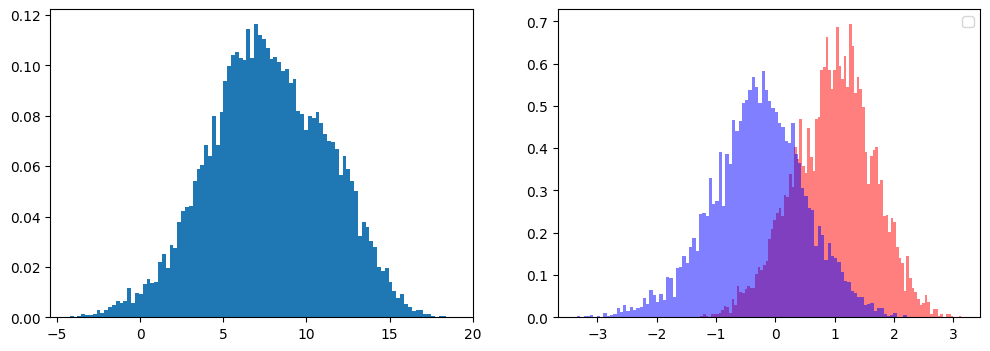

In [51]:
pyplot.figure(figsize=(12, 4))

pyplot.subplot(1, 2, 1)

_ = pyplot.hist(score, bins=100, density=True)

pyplot.subplot(1, 2, 2)

_ = pyplot.hist(ordered_pairs['sigma_score_1'].values, bins=100, density=True, alpha=0.5, color='r')
_ = pyplot.hist(ordered_pairs['sigma_score_2'].values, bins=100, density=True, alpha=0.5, color='b')
pyplot.legend()

# save model

In [52]:
os.makedirs(os.path.split(WEIGHT_PATH)[0], exist_ok=True)
torch.save(model.state_dict(), WEIGHT_PATH)
np.savez(
    WEIGHT_PATH.replace('.pt', '.npz'), 
    mean=score_mean,
    std=score_std,
)

In [22]:
raise

RuntimeError: No active exception to reraise

# check

In [53]:
# MINIO_ADDRESS = "123.176.98.90:9000"
MINIO_ADDRESS = "192.168.3.5:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"
bucket_name = 'datasets'

In [54]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

from utility.minio.cmd import connect_to_minio_client

In [55]:
client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)

Connecting to minio client...
Successfully connected to minio client...


In [56]:
def get_image_by_path(file_path):
    
    data = client.get_object(bucket_name=bucket_name, object_name=f'{file_path}.jpg')

    return Image.open(BytesIO(data.data))

def show_images(file_paths):

    num_rows = max(1, int(np.floor(len(file_paths) ** 0.5)))
    file_paths = file_paths[:num_rows * num_rows]

    target_size = 1024 // num_rows

    images = list()
    for file_path in tqdm(file_paths, leave=False):
        img = get_image_by_path(file_path)
        images.append(np.array(img.resize((target_size, target_size))))

    images = np.stack(images)
    images = images.reshape(num_rows, num_rows, target_size, target_size, 3)
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    return Image.fromarray(images)

def show_pairs(file_paths_1, file_paths_2):

    n = len(file_paths_1)

    target_size = 1024 // n

    images_1 = list()
    for file_path in tqdm(file_paths_1, leave=False):
        img = get_image_by_path(file_path)
        images_1.append(np.array(img.resize((target_size, target_size))))

    images_1 = np.stack(images_1)
    images_1 = np.concatenate(images_1, axis=-2)

    images_2 = list()
    for file_path in tqdm(file_paths_2, leave=False):
        img = get_image_by_path(file_path)
        images_2.append(np.array(img.resize((target_size, target_size))))

    images_2 = np.stack(images_2)
    images_2 = np.concatenate(images_2, axis=-2)

    images = np.concatenate([images_1, images_2], axis=-3)
    
    return Image.fromarray(images)

## check pairs

In [57]:
selected = ordered_pairs.query('(sigma_score_1 - sigma_score_2 < -2) and sigma_score_2 > 1')
selected.head()

,image_1,image_2,index_1,index_2,file_path,sigma_score_1,sigma_score_2
216,waifu/0004/003848,waifu/0002/001550,2689,4655,datasets/waifu/data/ranking/aggregate/2023-10-...,-0.937832,1.108925
434,waifu/0004/003994,waifu/0004/003538,2667,2688,datasets/waifu/data/ranking/aggregate/2023-10-...,-0.296574,1.798497


In [ ]:
show_pairs(selected['image_1'][:8], selected['image_2'][:8])

  0%|          | 0/2 [00:00<?, ?it/s]

# check conflicts

In [ ]:
import networkx

In [ ]:
graph = networkx.DiGraph()

In [ ]:
# for img_1, img_2, sel_id in rank_pairs:
for img_1, img_2, sel_id in rank_pairs.itertuples(index=False, name=None):
    if sel_id == 0:
        graph.add_edge(img_2, img_1)
    else:
        graph.add_edge(img_1, img_2)

In [ ]:
len(graph.nodes), len(graph.edges)

In [ ]:
cycles = list(tqdm(networkx.simple_cycles(graph)))
len(cycles)

In [ ]:
subgraphs = list(networkx.weakly_connected_components(graph))
len(subgraphs)

# check transitive relationship

In [ ]:
trans_pairs = list()

for image_2, d in networkx.all_pairs_shortest_path_length(graph):
    
    for image_1, dist in d.items():
        
        if dist <= 1:
            continue
        
        trans_pairs.append((image_1, image_2, dist))
        
trans_pairs = pd.DataFrame(trans_pairs, columns=['image_1', 'image_2', 'dist'])
trans_pairs